In [1]:
from google.colab import drive
drive.mount('/content/drive')  # optional; press the link and authorize
# if you don't need Drive, skip this cell


Mounted at /content/drive


In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# sklearn imports
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Reproducibility
np.random.seed(42)
sns.set(style="whitegrid")
%matplotlib inline


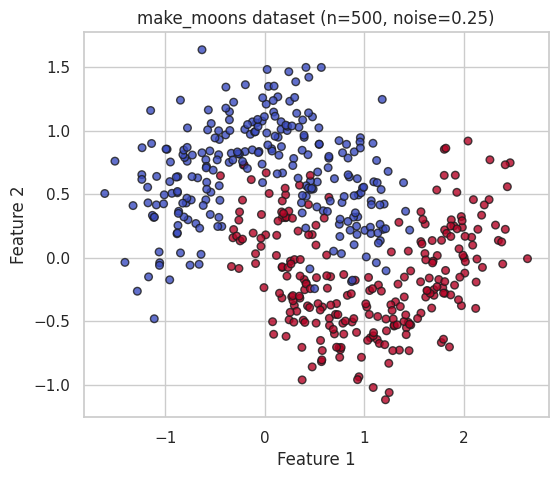

In [3]:
# Generate data
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)

# Quick scatter
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', s=30, edgecolor='k', alpha=0.8)
plt.title("make_moons dataset (n=500, noise=0.25)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Val shape:", X_val.shape)


Train shape: (350, 2) Val shape: (150, 2)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# quick check
print("Scaled mean (train):", np.round(X_train_scaled.mean(axis=0), 3))
print("Scaled std (train):", np.round(X_train_scaled.std(axis=0), 3))


Scaled mean (train): [-0. -0.]
Scaled std (train): [1. 1.]


In [6]:
def eval_and_print(model, X_val, y_val, name="Model"):
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"== {name} ==")
    print(f"Accuracy: {acc:.4f}")
    print("Classification report:")
    print(classification_report(y_val, y_pred, digits=4))
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    return acc, cm


Training time (s): 0.0171
== Linear SVM ==
Accuracy: 0.8400
Classification report:
              precision    recall  f1-score   support

           0     0.8228    0.8667    0.8442        75
           1     0.8592    0.8133    0.8356        75

    accuracy                         0.8400       150
   macro avg     0.8410    0.8400    0.8399       150
weighted avg     0.8410    0.8400    0.8399       150



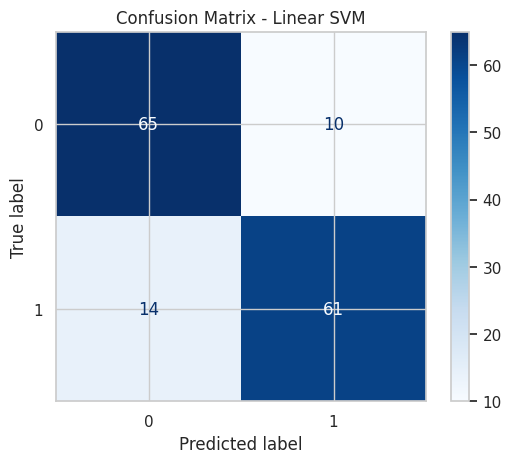

In [7]:
linear_model = SVC(kernel='linear', C=1.0, random_state=42)
t0 = time.time()
linear_model.fit(X_train_scaled, y_train)
t1 = time.time()
print("Training time (s):", round(t1-t0,4))
linear_acc, linear_cm = eval_and_print(linear_model, X_val_scaled, y_val, name="Linear SVM")


In [8]:
print("Analysis note:")
print("- Linear SVM tries to find a straight hyperplane. 'moons' is non-linear, so linear SVM will likely underfit.")
print("- The C parameter controls the soft margin (higher C => less regularization). Very small C => wider margin, more misclassifications.")


Analysis note:
- Linear SVM tries to find a straight hyperplane. 'moons' is non-linear, so linear SVM will likely underfit.
- The C parameter controls the soft margin (higher C => less regularization). Very small C => wider margin, more misclassifications.


Training time (s): 0.006
== RBF SVM (default) ==
Accuracy: 0.9467
Classification report:
              precision    recall  f1-score   support

           0     0.9241    0.9733    0.9481        75
           1     0.9718    0.9200    0.9452        75

    accuracy                         0.9467       150
   macro avg     0.9479    0.9467    0.9466       150
weighted avg     0.9479    0.9467    0.9466       150



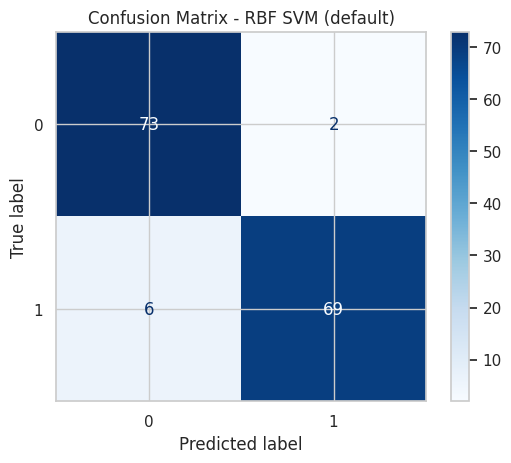

In [9]:
rbf_model = SVC(kernel='rbf', random_state=42)  # default C=1.0, gamma='scale'
t0 = time.time()
rbf_model.fit(X_train_scaled, y_train)
t1 = time.time()
print("Training time (s):", round(t1-t0,4))
rbf_acc, rbf_cm = eval_and_print(rbf_model, X_val_scaled, y_val, name="RBF SVM (default)")


Training time (s): 0.0053
== Polynomial SVM (deg=3) ==
Accuracy: 0.8400
Classification report:
              precision    recall  f1-score   support

           0     0.8493    0.8267    0.8378        75
           1     0.8312    0.8533    0.8421        75

    accuracy                         0.8400       150
   macro avg     0.8402    0.8400    0.8400       150
weighted avg     0.8402    0.8400    0.8400       150



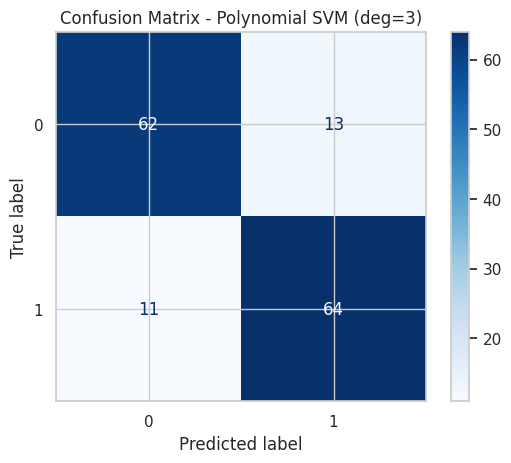

In [10]:
poly_model = SVC(kernel='poly', degree=3, random_state=42)
t0 = time.time()
poly_model.fit(X_train_scaled, y_train)
t1 = time.time()
print("Training time (s):", round(t1-t0,4))
poly_acc, poly_cm = eval_and_print(poly_model, X_val_scaled, y_val, name="Polynomial SVM (deg=3)")


In [11]:
import pandas as pd
results = pd.DataFrame({
    "Model": ["Linear", "RBF (default)", "Polynomial (deg3)"],
    "Validation Accuracy": [linear_acc, rbf_acc, poly_acc]
})
display(results)


,Model,Validation Accuracy
0,Linear,0.840000
1,RBF (default),0.946667
2,Polynomial (deg3),0.840000


In [12]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1, refit=True)
t0 = time.time()
grid.fit(X_train_scaled, y_train)
t1 = time.time()
print("GridSearch time (s):", round(t1-t0,3))
print("Best params:", grid.best_params_)
print("Best CV score:", round(grid.best_score_,4))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
GridSearch time (s): 4.591
Best params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best CV score: 0.9543


== Best GridSearch Model (RBF) ==
Accuracy: 0.9533
Classification report:
              precision    recall  f1-score   support

           0     0.9474    0.9600    0.9536        75
           1     0.9595    0.9467    0.9530        75

    accuracy                         0.9533       150
   macro avg     0.9534    0.9533    0.9533       150
weighted avg     0.9534    0.9533    0.9533       150



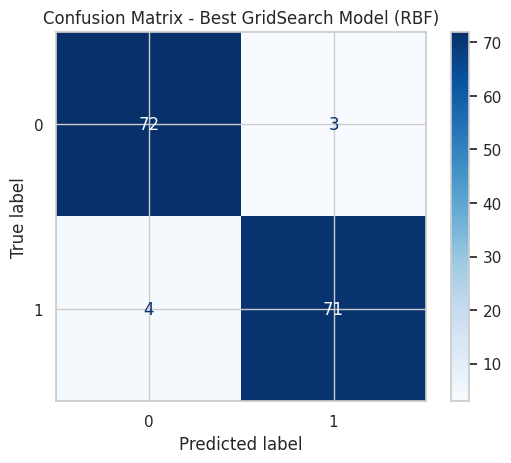

In [13]:
best_model = grid.best_estimator_
best_acc, best_cm = eval_and_print(best_model, X_val_scaled, y_val, name=f"Best GridSearch Model (RBF)")


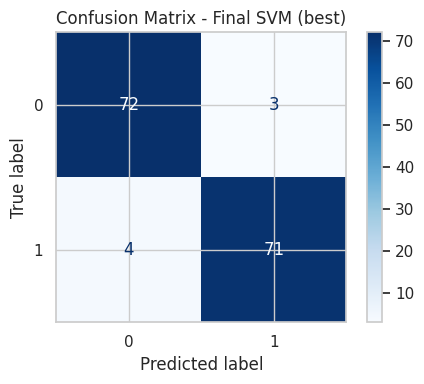

Saved: svm_final_confusion_matrix.png


In [14]:
# Save confusion matrix figure for Overleaf
fig = plt.figure(figsize=(5,4))
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm)
disp.plot(cmap='Blues', ax=fig.gca())
plt.title("Confusion Matrix - Final SVM (best)")
plt.tight_layout()
plt.savefig("svm_final_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
print("Saved: svm_final_confusion_matrix.png")


In [15]:
def plot_decision_boundary(model, X_scaled, y, ax, title="Decision boundary", cmap='coolwarm', points_alpha=0.7):
    # Create meshgrid in scaled feature space
    x_min, x_max = X_scaled[:,0].min() - 0.5, X_scaled[:,0].max() + 0.5
    y_min, y_max = X_scaled[:,1].min() - 0.5, X_scaled[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    scatter = ax.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap=cmap, s=30, edgecolor='k', alpha=points_alpha)
    ax.set_title(title)
    ax.set_xlabel("Feature 1 (scaled)")
    ax.set_ylabel("Feature 2 (scaled)")
    return ax


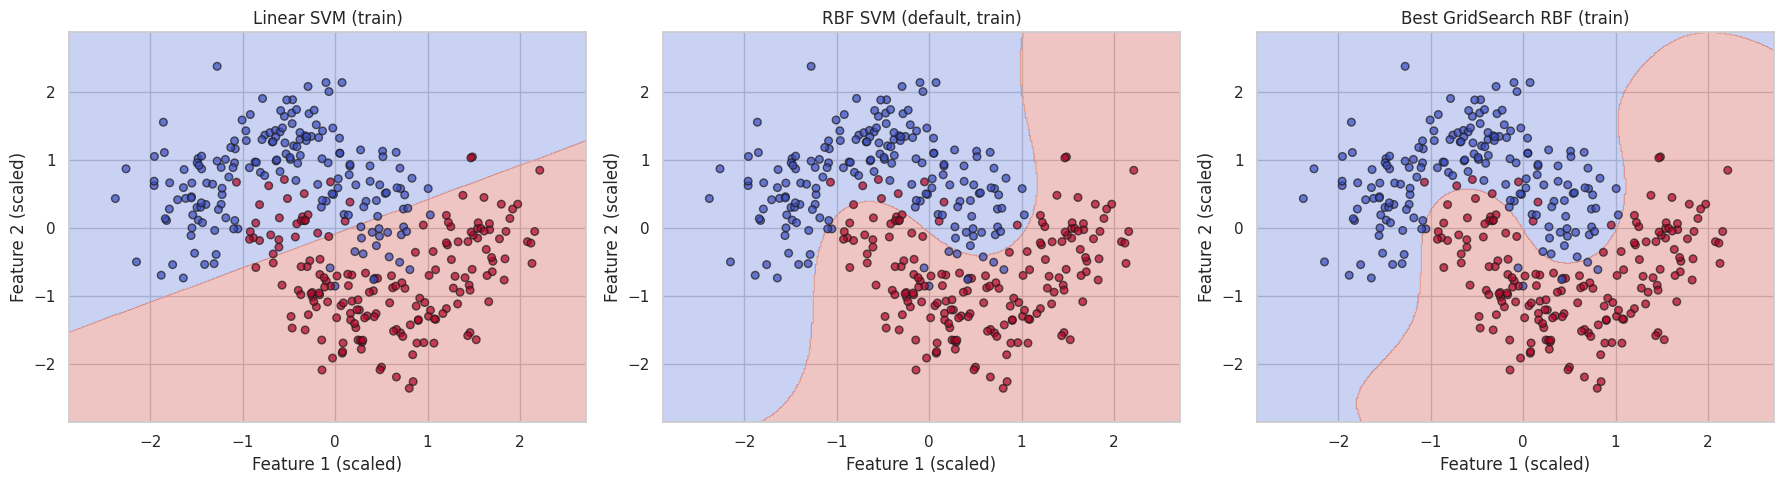

Saved: svm_decision_boundaries.png


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# linear
plot_decision_boundary(linear_model, X_train_scaled, y_train, axes[0], title="Linear SVM (train)")

# default rbf (trained earlier on train set)
plot_decision_boundary(rbf_model, X_train_scaled, y_train, axes[1], title="RBF SVM (default, train)")

# best model from grid (refit on full train)
plot_decision_boundary(best_model, X_train_scaled, y_train, axes[2], title="Best GridSearch RBF (train)")

plt.tight_layout()
plt.savefig("svm_decision_boundaries.png", dpi=300, bbox_inches='tight')
plt.show()
print("Saved: svm_decision_boundaries.png")


In [17]:
models = [("Linear", linear_model), ("RBF default", rbf_model), ("RBF best", best_model)]
for name, m in models:
    acc = accuracy_score(y_val, m.predict(X_val_scaled))
    print(f"{name}: Val Accuracy = {acc:.4f}")


Linear: Val Accuracy = 0.8400
RBF default: Val Accuracy = 0.9467
RBF best: Val Accuracy = 0.9533


In [18]:
import joblib
joblib.dump(best_model, "svm_best_model.joblib")
print("Saved best model to svm_best_model.joblib")
# if you used Drive and want to save there, uncomment and change path:
# joblib.dump(best_model, "/content/drive/MyDrive/svm_best_model.joblib")


Saved best model to svm_best_model.joblib


In [19]:
print("===== Final summary =====")
print("Best GridSearch parameters:", grid.best_params_)
final_val_pred = best_model.predict(X_val_scaled)
print("Final Validation Accuracy:", round(accuracy_score(y_val, final_val_pred), 4))
print("Classification report for final model:")
print(classification_report(y_val, final_val_pred, digits=4))


===== Final summary =====
Best GridSearch parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Final Validation Accuracy: 0.9533
Classification report for final model:
              precision    recall  f1-score   support

           0     0.9474    0.9600    0.9536        75
           1     0.9595    0.9467    0.9530        75

    accuracy                         0.9533       150
   macro avg     0.9534    0.9533    0.9533       150
weighted avg     0.9534    0.9533    0.9533       150



In [20]:
from IPython.display import Markdown, display

observation_md = """
**Observation:**
- The linear SVM fails to separate the non-linearly separable 'moons' data because a straight hyperplane cannot capture the curved boundary.
- Kernelized SVMs (RBF and Polynomial) transform the data implicitly and can form non-linear decision boundaries; RBF usually performs best on moons.
- GridSearchCV tuning of `C` and `gamma` for the RBF kernel significantly improves validation accuracy by balancing margin width (C) and kernel influence (gamma).
"""

display(Markdown(observation_md))

latex_snippet = r"""
\textbf{Observation:} \\
\begin{itemize}
  \item The linear SVM fails to separate the non-linear `moons' data because a straight hyperplane cannot capture the curved boundary.
  \item Kernelized SVMs (RBF and Polynomial) can form non-linear decision boundaries; RBF often performs best for the moons dataset.
  \item GridSearchCV tuning for `C` and `gamma` significantly improves validation accuracy by balancing margin regularization and kernel influence.
\end{itemize}
"""
with open("observation.tex", "w", encoding="utf-8") as f:
    f.write(latex_snippet)
print("Saved: observation.tex")



**Observation:**  
- The linear SVM fails to separate the non-linearly separable 'moons' data because a straight hyperplane cannot capture the curved boundary.  
- Kernelized SVMs (RBF and Polynomial) transform the data implicitly and can form non-linear decision boundaries; RBF usually performs best on moons.  
- GridSearchCV tuning of `C` and `gamma` for the RBF kernel significantly improves validation accuracy by balancing margin width (C) and kernel influence (gamma).


Saved: observation.tex
